In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

In [2]:
import os
os.listdir("../input/digit-recognizer")

['train.csv', 'sample_submission.csv', 'test.csv']

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"../input/digit-recognizer/train.csv",dtype = np.float32)

In [4]:
# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

In [5]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [6]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

In [7]:
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [8]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

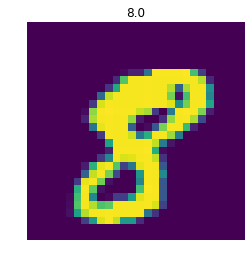

In [9]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [10]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [11]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create ANN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.10659419000148773  Accuracy: 96.72618865966797 %
Iteration: 1000  Loss: 0.03585902601480484  Accuracy: 97.71428680419922 %
Iteration: 1500  Loss: 0.030054286122322083  Accuracy: 97.8452377319336 %
Iteration: 2000  Loss: 0.015666835010051727  Accuracy: 98.29762268066406 %


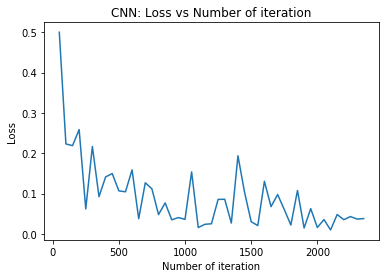

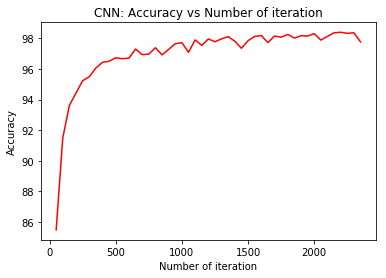

In [13]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [14]:
loss.data

tensor(0.0059)